# Projet file rouge : Allstate Claims Severity

## Présentation du sujet:

$\textbf{Allstate}$ est une compagnie d'assurance qui s'est mise au point des méthodes automatisées de prévision du coût, et donc de la gravité, des sinistres. 

Le but du projet étant de prédir la sévérité des sinistres.

Nous disposons de deux bases de données contenant des sinistres historiques et leurs différents coûts. Une base qui nous servira pour entraîner les différents modèles predictives que nous allons élaborer, et une base test sur laquelle nous allons tester la performance du modèle prédictive.

les bases de données contient des variables quantitatives (cont1,cont2...) et des variables qualitatives (cat1,cat2,...) ainsi que la variable à prédire notée "loss".

La difficulté reside dans le fait que nous avons pas les vrais labels des variables ce qui compliquera la compréhension des resultats.

Etapes de l'études:
    
        1- Analyse descriptive : 
        2- Création des classes par prix:K-means
        2- ACP,Regression linéaire, 
        


#Commentaires:

        - Utilisation de l'ACP que lorsqu'il a présence des variables corrélées

In [159]:
#Library
from sklearn import linear_model as lm
import cupy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score,auc,confusion_matrix
from sklearn.model_selection import train_test_split

### Importation et lecture des données

In [89]:
def import_data(file):
    #Data import
    data=pd.read_csv(file,sep=',',header=0)
    data=pd.DataFrame(data)
    data=data.drop("id",axis=1) #Suppression de la colonne "id"
    return data
    
file='C:/Users/Grabus2/Desktop/Allstate Claims severity/train.csv'
df=import_data(file)

## Exploration des données

In [90]:
#Extrait du Data
data.head(10)

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,A,B,A,B,A,A,A,A,B,A,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,A,B,A,A,A,A,A,A,B,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,A,B,A,A,B,A,A,A,B,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,B,B,A,B,A,A,A,A,B,A,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,A,B,A,B,A,A,A,A,B,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85
5,A,B,A,A,A,A,A,A,B,A,...,0.364464,0.401162,0.26847,0.46226,0.50556,0.366788,0.359249,0.345247,0.726792,5142.87
6,A,A,A,A,B,A,A,A,A,A,...,0.381515,0.363768,0.24564,0.40455,0.47225,0.334828,0.352251,0.342239,0.382931,1132.22
7,A,B,A,B,A,A,A,A,B,A,...,0.867021,0.583389,0.90267,0.84847,0.80218,0.644013,0.785706,0.859764,0.242416,3585.75
8,A,B,B,B,B,A,A,A,B,B,...,0.628534,0.384099,0.61229,0.38249,0.51111,0.682315,0.669033,0.756454,0.361191,10280.20
9,A,B,A,A,B,B,A,A,B,A,...,0.713343,0.469223,0.30260,0.67135,0.83510,0.863052,0.879347,0.822493,0.294523,6184.59


In [91]:
#data size
def size(data):
    print("nombre d'observations (lignes):",data.shape[0])
    print("nombre de variables (colonnes):",data.shape[1])

    #Verification des valeur 
    nan_count=sum(len(data)-data.count())
    print("Nombre des valeurs manquantes:",nan_count)
size_data=size(data)

nombre d'observations (lignes): 188318
nombre de variables (colonnes): 131
Nombre des valeurs manquantes: 0


In [92]:
#informations générales
def describe(data):
    return data.describe()
describe(data)

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


In [149]:
#Séparation des variables explicatives du la variable à prédir
def X_Y(data,target):
    X=data.drop("loss",axis=1) #variables explicatives
    Y=data["loss"] #variable à expliquer


#Séparation des variables explicatives en deux ensembles : Variables quantitatives et qualitatives
def var_quanti(data):
    # variables numeriques
    var_num = [col for col in data if 'cont' in col]
    var_num=pd.DataFrame(var_num,columns=['variables quantitatives'])
    print('nombre de variables quantitatives :',len(var_num))
    return var_num
var_quanti(data)


def var_quali(data):
    # Variables categorielles
    var_cat = [col for col in data if 'cat' in col]
    var_cat=pd.DataFrame(var_cat,columns=['variables qualitatives'])
    print('nombre de variables qualitatives  :',len(var_cat))
    return var_cat
var_quali(data)

nombre de variables quantitatives : 14
nombre de variables qualitatives  : 116


,variables qualitatives
0,cat1
1,cat2
2,cat3
3,cat4
4,cat5
5,cat6
6,cat7
7,cat8
8,cat9
9,cat10


In [116]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 131 entries, cat1 to loss
dtypes: float64(15), object(116)
memory usage: 188.2+ MB


-Après avoir détérminer le nombre des variables catégorielles et numériques, regardons combien nous avons de valeurs uniques dans chaque variables catégorielle ainsi que la corrégaltion entre les variables continues (numériques).

## Les valeurs uniques dans les variables catégorielles

In [118]:
data.dtypes;
#object
#float64

In [140]:
var_cat=var_quali(data)['variables qualitatives']
cat_uniques = []
for cat in var_cat:
    cat_uniques.append(len(data[cat].unique()))
    
unique_values = pd.DataFrame({'cat_name': var_cat, 'unique_values': cat_uniques})
print(unique_values)
print(unique_values.describe())

    cat_name  unique_values
0       cat1              2
1       cat2              2
2       cat3              2
3       cat4              2
4       cat5              2
5       cat6              2
6       cat7              2
7       cat8              2
8       cat9              2
9      cat10              2
10     cat11              2
11     cat12              2
12     cat13              2
13     cat14              2
14     cat15              2
15     cat16              2
16     cat17              2
17     cat18              2
18     cat19              2
19     cat20              2
20     cat21              2
21     cat22              2
22     cat23              2
23     cat24              2
24     cat25              2
25     cat26              2
26     cat27              2
27     cat28              2
28     cat29              2
29     cat30              2
..       ...            ...
86     cat87              4
87     cat88              4
88     cat89              8
89     cat90        

Commentaire:
        
        - Nous remarquons que les modalités des variables catégorielles varient entre 2 et 326.

# Data visualisation

## Analyse de corrélation entre les variables continues

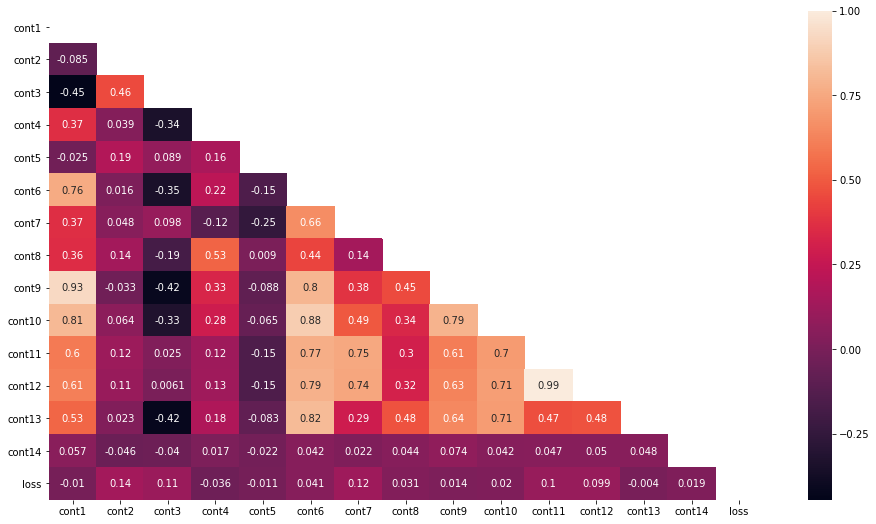

In [141]:
cmap = sns.diverging_palette(110, 20, as_cmap=True)
corr=data.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(corr, annot = True,mask=mask)


Intérpretation:
        
     -Nous remarquons qu'il y a des corrélation entre certaines variables,par exemplbe une corrélation de 88% entre cont6 et cont10 et 93% entre cont1 et cont9.
     

### Visualisation du comportement de la variable prédictive

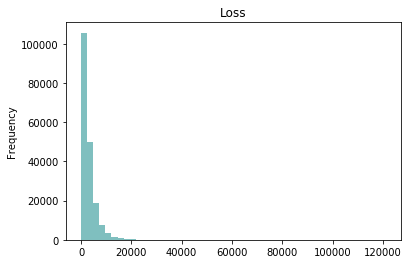

Moyenne de Y : 3037.338
Maximum de Y : 121012.25
Minimum de Y : 0.67
Mediane de Y : 2115.57
Skewness :  3.79


In [142]:
plt.figure()
data['loss'].plot.hist(alpha=0.5, color = 'teal', bins = 50)
plt.title("Loss")
# plt.savefig('images/loss.png')
plt.show()
#
skewness = scipy.stats.skew(data["loss"])
#boxplot des variables quantitatives
print("Moyenne de Y :",np.around(np.mean(Y),3))
print("Maximum de Y :",np.around(np.max(Y),3))
print("Minimum de Y :",np.around(np.min(Y),3))
print("Mediane de Y :",np.around(np.median(Y),3))
print("Skewness : ",np.around(skewness,2))

Commentaire:
    
    - Nous remarquons que la variable des loss a un skewness étalé à gauche, le skewness mesure l'assymétrie de la varibale par rapport a sa moyenne. Cette asymétrie peut impacter la pérformance de nos modèles prédictives d'ou la nécessité d'utiliser une transformation afin de corriger cette asymétrie. 

### Transformation logaritmique de la variable prédictive

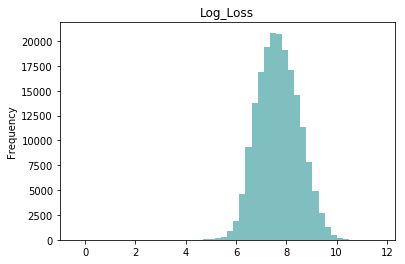

In [143]:
loss_log=np.log(data['loss'])
loss_log.plot.hist(alpha=0.5, color = 'teal', bins = 50)
plt.title("Log_Loss")
# plt.savefig('images/loss.png')
plt.show()


Commentaire:
    
    - Nous remarquons qu'en appliquant une transformation logarithmique, l'asymétrie de la variable a été corrigée.

nombre de variables quantitatives : 14


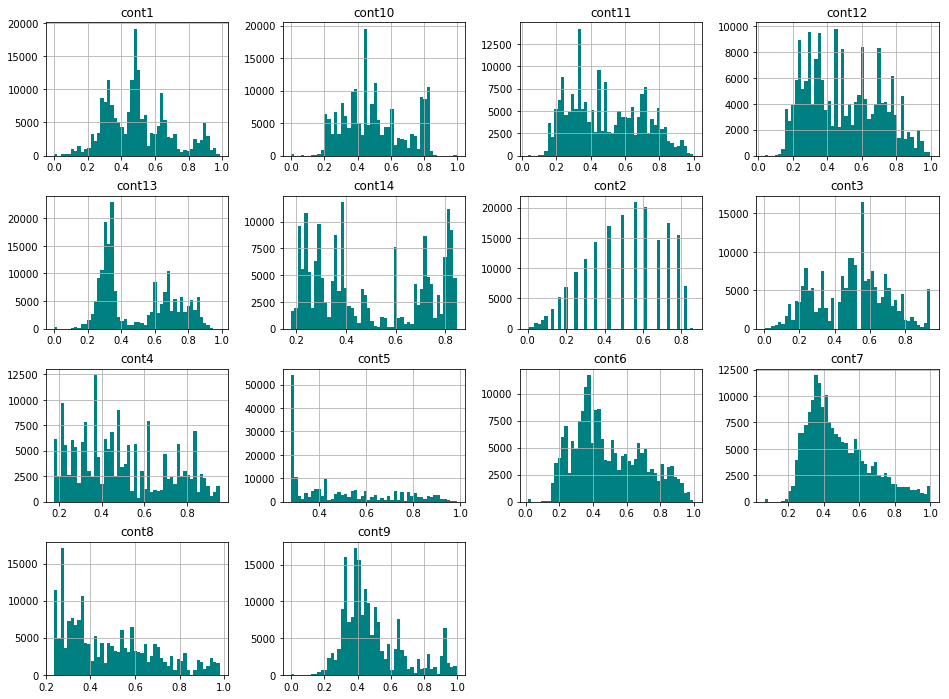

In [150]:
var_num=var_quanti(data)['variables quantitatives']
data[var_num].hist(bins=50, figsize=(16,12), color = 'teal')
# plt.savefig('images/conts.png')
plt.show()

### Encodage des variables

Dans cette partie nous allons mettre les variables catégorielles sous format numériques afin que nous puissions les utiliser dans nos modèles prédictives

In [151]:
# first, we convert the categorical variables into numbers
data_copy = data.copy()
categoricals = data_copy.loc[:, var_cat]
for cat_feat in categoricals.columns:
    categoricals[cat_feat] = pd.factorize(categoricals[cat_feat], sort=True)[0]

In [152]:
#Variable Cat aprés encodage
categoricals.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,0,1,0,1,0,0,0,0,1,0,...,9,6,45,28,2,19,55,0,14,269
1,0,1,0,0,0,0,0,0,1,1,...,10,10,33,65,0,22,38,0,14,85
2,0,1,0,0,1,0,0,0,1,1,...,5,0,2,85,0,28,5,0,8,153
3,1,1,0,1,0,0,0,0,1,0,...,10,10,33,67,2,39,4,0,14,79
4,0,1,0,1,0,0,0,0,1,1,...,6,1,66,50,2,50,38,0,10,55


#### Visualisation de quelques variables catégorielle après encodage 

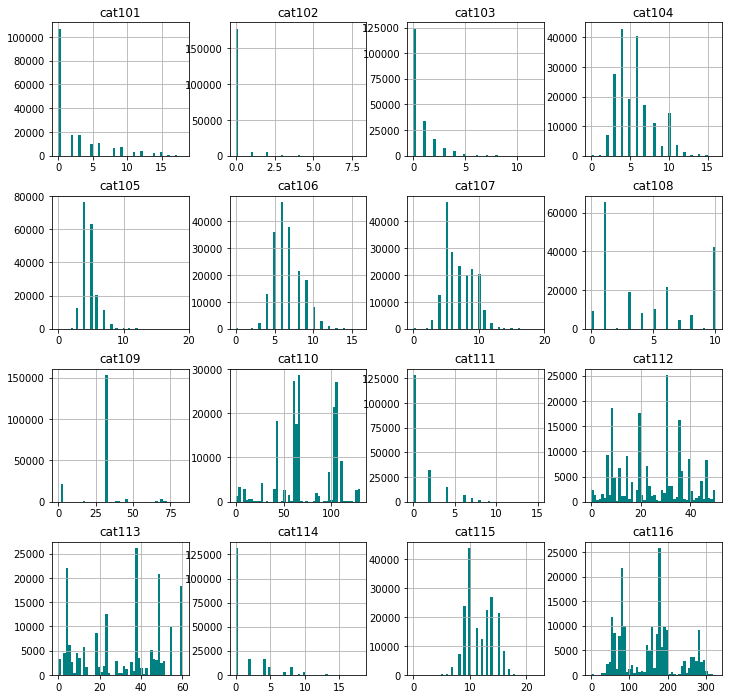

In [153]:
# plot a few columns
categoricals.iloc[:,100:116].hist(bins = 50, figsize = (12, 12), color = 'teal')
# plt.savefig('images/cats.png')
plt.show()

Commentaires:
    
    -Nous remarquons que les variables ci-dessous ne se comportent pas de la même façon. 
    -Aucune variable ne peut être considérée comme gaussienne à part peut-être la variable cat06
    -Plusieurs variables dispose de multiples pic (cat116,cat110...)

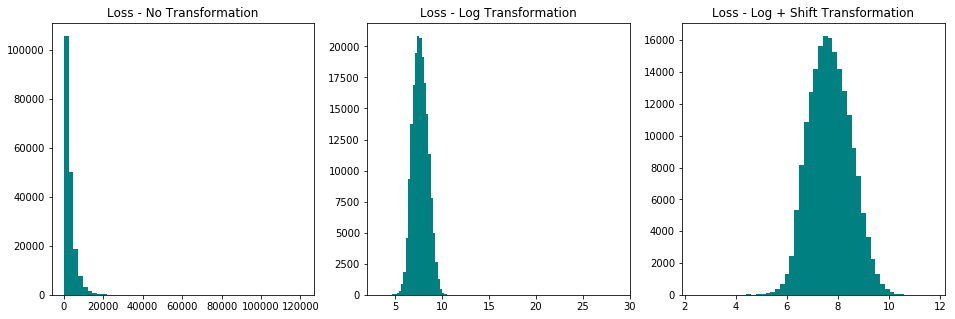

In [154]:
default_loss = data['loss']
log_loss = np.log(data['loss'])
log_shift_loss = np.log(data['loss'] + 10)

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(16,5)
ax1.hist(default_loss, bins = 50, color = 'teal')
ax1.set_title('Loss - No Transformation')

ax2.set_xlim(2,30)
ax2.set_title('Loss - Log Transformation')
ax2.hist(log_loss, bins = 50, color = 'teal')

ax3.set_title('Loss - Log + Shift Transformation')
ax3.hist(log_shift_loss, bins = 50, color = 'teal')
plt.show()
# fig.savefig('images/loss_transformed.png')

# Classification

In [155]:
X=pd.concat((categoricals,data[var_num[0]]),axis=1)
Y=data['loss']

### Split des données

In [156]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42) 

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=4).fit(X)
scores=cross_val_score(kmeans,X,Y,cv=10)
scores

In [163]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def cross_validate(n_folds, X,Y,clf):
    accuracy = []
    kf = KFold(n_folds, shuffle=True)# shuffle=True,
                               
    for train_index, test_index in kf:
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        clf.fit(X_train,y_train)
        predictions = clf.predict(X_test)
        accuracy.append(mean_squared_error(y_test,predictions))
        print(accuracy)
        
    return clf,np.array(accuracy)

cross_validate(3,X_train,Y_train,kmeans)

TypeError: 'KFold' object is not iterable